# Analysis of ephys in motor learing task during voltage imaging

This is an adoptive code based on `analyze_ephys_MotorLearning_during_VoltageImaging.py` from TK.

In [1]:
import numpy as np
from pathlib import Path
import pandas as pd
from sys import platform
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
vol_file = Path('../Voltron_data/Voltron_Log_DRN_Exp.csv')
dat_xls_file = pd.read_csv(vol_file, index_col=0)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')
# using Path to handle switches filesystems
if platform == "linux" or platform == "linux2":
    dir_folder = Path('/nrs/ahrens/Ziqiang/Takashi_DRN_project/ProcessedData/')
elif platform == 'win32':
    dir_folder = Path('U:\\Takashi') # put folder for windows system
# All files are preprocessed using DRN_swim_processing.py

In [3]:
include_exp=np.ones((len(dat_xls_file),))
power_dist=np.zeros((len(dat_xls_file),))

for index, row in dat_xls_file.iterrows():
    if not row['task']=='Raphe memory task':
            continue
    folder = row['folder']
    fish = row['fish']
    swimdir = dir_folder/f'{folder}/{fish}/swim'
    blockpowers=np.load(swimdir/"blockpowers.npy")[()]
    power_dist[index]=blockpowers[2,:].mean()
    swim_powers=np.load(swimdir/"swim_powers.npy")[()]
    swim_powers_training5s = np.load(swimdir/"swim_powers_training5s.npy")[()]; #swim power in the last 5s of training period
    # criterion 1 by power
    if power_dist[index]>=1:
        include_exp[index]=0  
    # criterion 2 by spontaneous swimming
    include_matrix=np.zeros((swim_powers.shape[0]))    
    swim_powers_init     = swim_powers[:,[0,4,8]];
    swim_powers_training = swim_powers_training5s;
    swim_powers_delay    = swim_powers[:,[2,6,10]];
    delay_thre=(swim_powers_training.flatten().mean())/4
    include_matrix=[(swim_powers_delay<delay_thre)][0]  
    include_sum=include_matrix.sum(axis=0)
    np.save(swimdir/"include_matrix",include_matrix);
    # criteria by swimming during OMR
    if include_sum.min()<3:
        include_exp[index]=2
    if swim_powers_init.mean()<(swim_powers_training.mean()*2):
        include_exp[index]=3
    train_mean =  swim_powers_training5s.mean(axis=0)
    if not train_mean.mean()==0:
        train_mean /= train_mean.mean()
    if (train_mean.min()< 0.4 or train_mean.max()>1.6):
        include_exp[index]=4
    
include_inds=np.where(include_exp==0)[0]
curated_xls_file=dat_xls_file.iloc[include_inds]
print(f'Number of valid sessions {len(include_inds)}')
print(f'Valid session indices: {include_inds}')

Number of valid sessions 16
Valid session indices: [ 4  5 11 12 13 14 22 31 32 33 34 38 39 43 52 54]


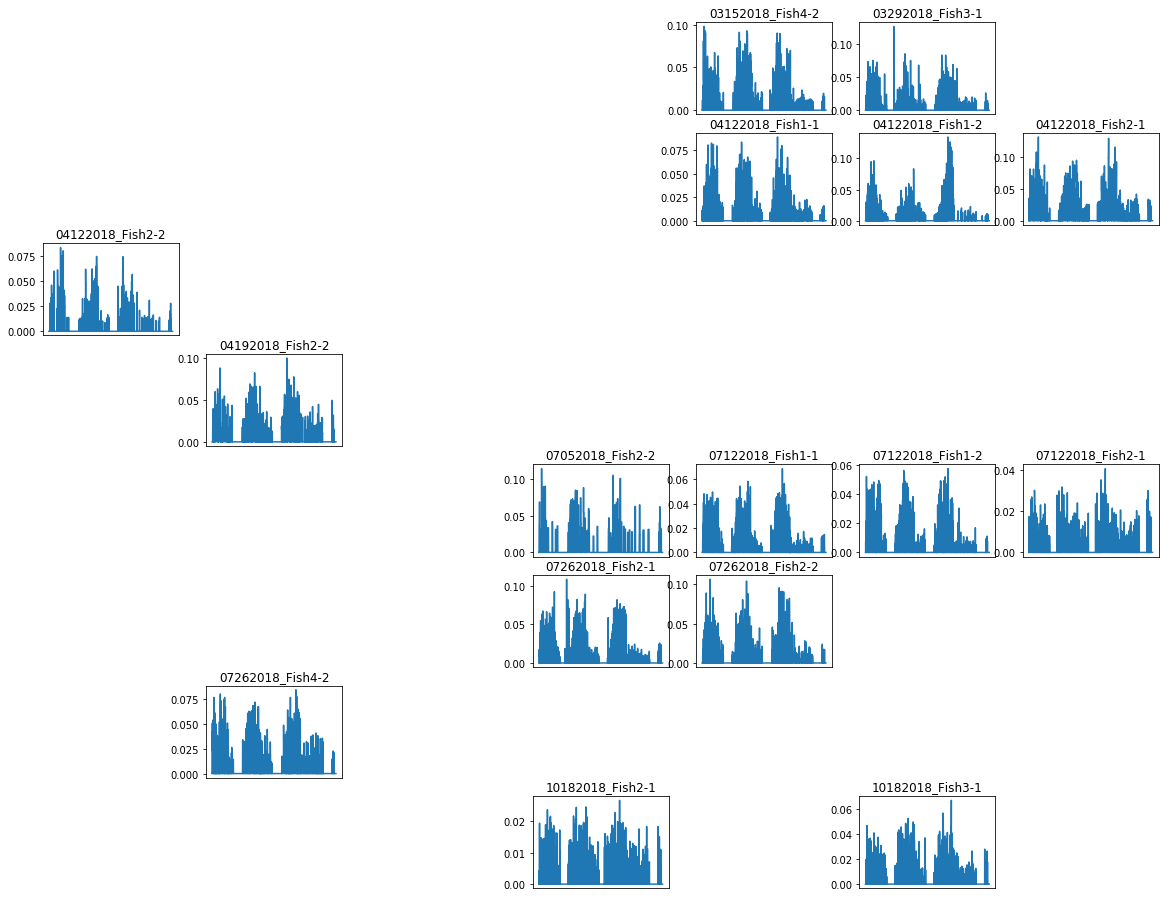

In [4]:
# 3 sessions and 4 epochs
swim_power_summaries = np.empty((len(dat_xls_file),3,4))
swim_power_summaries[:] = np.nan
fbout_power_summaries = np.empty((len(dat_xls_file),3))
fbout_power_summaries[:] = np.nan
m = len(dat_xls_file)//10+1

plt.figure(figsize=(20, 20))
for index, row in curated_xls_file.iterrows():
    folder = row['folder']
    fish = row['fish']
    swimdir = dir_folder/f'{folder}/{fish}/swim'
    swim_nums = np.load(swimdir/"swim_nums.npy")[()];
    swim_shapes = np.load(swimdir/"swim_shapes.npy")[()];
    swim_powers =np.load(swimdir/"swim_powers.npy")[()];
    fbout_powers =np.load(swimdir/"fbout_powers.npy")[()];
    swim_powers_training5s =np.load(swimdir/"swim_powers_training5s.npy")[()];    
    plt.subplot(10,m,index+1).plot(swim_shapes.mean(axis=0))
    plt.xticks([])
    plt.title(f'{folder}_{fish}')
    swim_powers_init = swim_powers[:,[0,4,8]]
    #swim_powers_training = swim_powers[:,[1,5,9]]
    swim_powers_training = swim_powers_training5s
    swim_powers_delay = swim_powers[:,[2,6,10]]
    swim_powers_test = swim_powers[:,[3,7,11]]
    delay_thre=(swim_powers_training.flatten().mean())/4    
    swim_power_summaries[index,:,0] = np.nanmean(swim_powers_init, axis=0)
    swim_power_summaries[index,:,1] = np.nanmean(swim_powers_training,axis=0)
    swim_power_summaries[index,:,2] = np.nanmean(swim_powers_delay,axis=0)
    swim_power_summaries[index,:,3] = np.nanmean(swim_powers_test,axis=0)    
    div= swim_power_summaries[index,:,1].mean()    
    swim_power_summaries[index,:,0] /= swim_power_summaries[index,:,0].mean()
    swim_power_summaries[index,:,1] /= div
    swim_power_summaries[index,:,2] /= div
    swim_power_summaries[index,:,3] /= swim_power_summaries[index,:,3].mean()   
    fbout_power_test=fbout_powers[:,[3,7,11]].mean(axis=0)
    fbout_power_summaries[index,:]=fbout_power_test/fbout_power_test.mean()
plt.show()

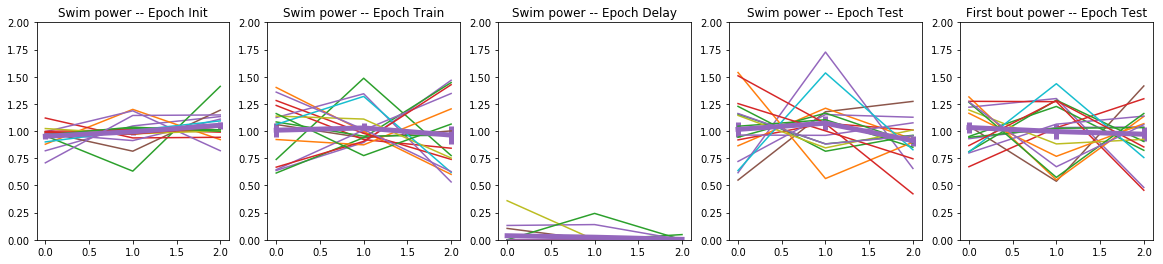

In [5]:
plt.figure(figsize=(20, 4))
plt.subplot(1,5,1).plot(swim_power_summaries[:,:,0].T)
plt.errorbar(np.arange(3),np.nanmean(swim_power_summaries[:,:,0],axis=0),np.nanstd(swim_power_summaries[:,:,0],axis=0)/np.sqrt(len(include_inds)),linewidth=5)
plt.title('Swim power -- Epoch Init')
plt.ylim([0, 2])

plt.subplot(1,5,2).plot(swim_power_summaries[:,:,1].T)
plt.errorbar(np.arange(3),np.nanmean(swim_power_summaries[:,:,1],axis=0),np.nanstd(swim_power_summaries[:,:,1],axis=0)/np.sqrt(len(include_inds)),linewidth=5)
plt.title('Swim power -- Epoch Train')
plt.ylim([0, 2])

plt.subplot(1,5,3).plot(swim_power_summaries[:,:,2].T)
plt.plot(np.nanmean(swim_power_summaries[:,:,2],axis=0),linewidth=5)
plt.title('Swim power -- Epoch Delay')
plt.ylim([0, 2])

plt.subplot(1,5,4).plot(swim_power_summaries[:,:,3].T)
plt.errorbar(np.arange(3),np.nanmean(swim_power_summaries[:,:,3],axis=0),np.nanstd(swim_power_summaries[:,:,3],axis=0)/np.sqrt(len(include_inds)),linewidth=5)
plt.title('Swim power -- Epoch Test')
plt.ylim([0, 2])

plt.subplot(1,5,5).plot(fbout_power_summaries.T)
plt.errorbar(np.arange(3),np.nanmean(fbout_power_summaries,axis=0),np.nanstd(fbout_power_summaries,axis=0)/np.sqrt(len(include_inds)),linewidth=5)
plt.title('First bout power -- Epoch Test')
plt.ylim([0, 2])

plt.show()